In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit import QuantumCircuit, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit import transpile
from qiskit.tools.monitor import job_monitor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

import pandas as pd
import seaborn as sns
import numpy as np
import time
import psutil
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Set seed for random generators
algorithm_globals.random_seed = 42


## Support functions

In [2]:
# Define functions to measure accuracy and resource consumption
def measure_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)['accuracy']


def measure_resources():
    cpu = psutil.cpu_percent()
    memory = psutil.virtual_memory().percent
    return cpu, memory  


backend = FakeVigoV2()


In [3]:
provider = AzureQuantumProvider(
    resource_id="/subscriptions/d8e1bc73-11fa-45f6-a5d6-fdedc9b01dab/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QMLUCD",
    location="UK West"
)

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())


This workspace's targets:
- ionq.simulator
- ionq.simulator
- ionq.simulator
- ionq.qpu
- ionq.qpu
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s1-apival
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1sc
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s2-apival
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-2sc
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s1-sim
- quantinuum.sim.h1-1e
- quantinuum.sim.h1-1e
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.sim.h1-2e
- quantinuum.sim.h1-2e
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1
- quantinuum.qpu.h1-1
- quantinuum.qpu.h1-1
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2
- quantinuum.qpu.h1-2
- quantinuum.qpu.h1-2
- rigetti.sim.qvm
- rigetti.qpu.aspen-m-2
- rigetti.qpu.aspen-m-3
- microsoft.estimator


In [4]:
simulator_backend = provider.get_backend("ionq.simulator")
ionq_backend = provider.get_backend("ionq.qpu")
quantinuum_backend = provider.get_backend("quantinuum.hqs-lt-s1-apival")
rigetti_backend = provider.get_backend("rigetti.qpu.aspen-m-3")


# Load the data

In [5]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

# Load data
iris_data = load_iris()
wine_data = load_wine()
breast_cancer_data = load_breast_cancer()


# Process Data

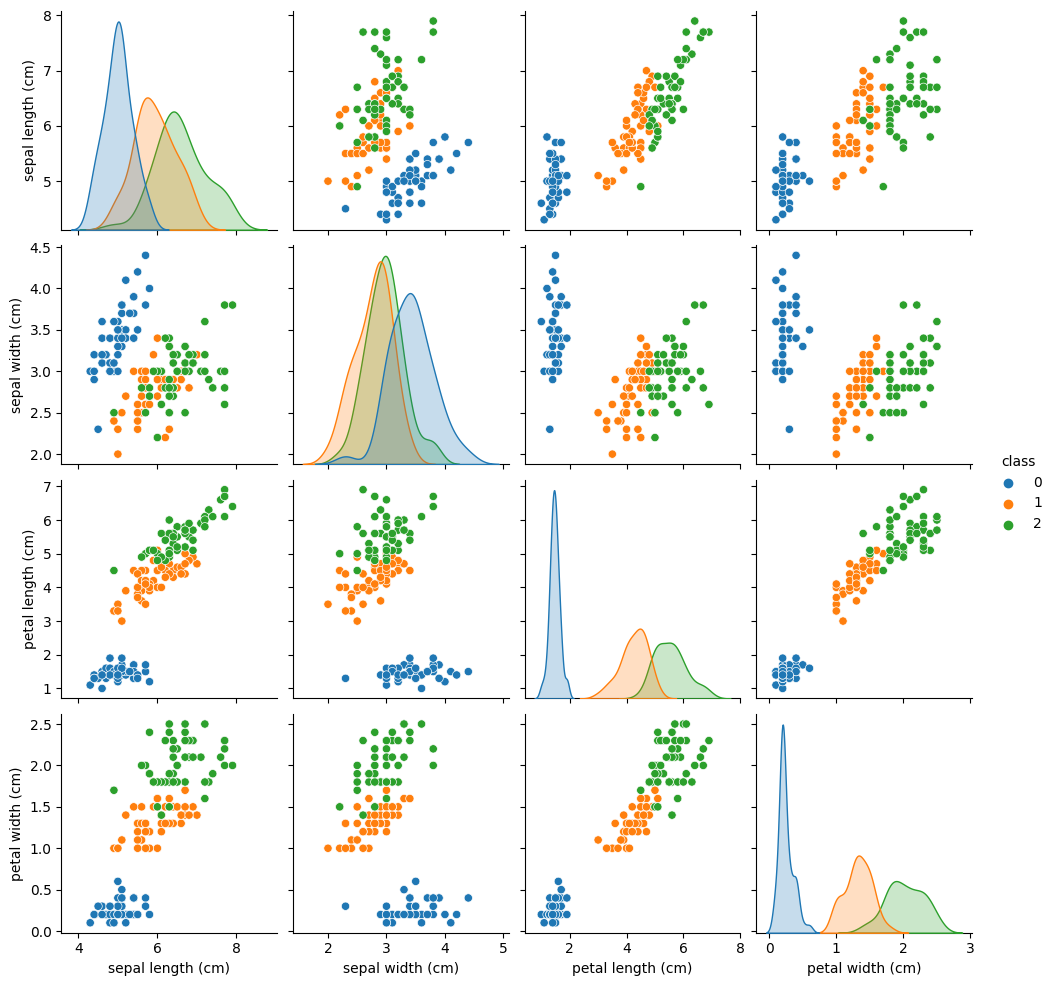

In [6]:
iris_features = iris_data.data
iris_labels = iris_data.target

iris_features = MinMaxScaler().fit_transform(iris_features)

iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["class"] = pd.Series(iris_data.target)

sns.pairplot(iris_df, hue="class", palette="tab10")


# Process wine data

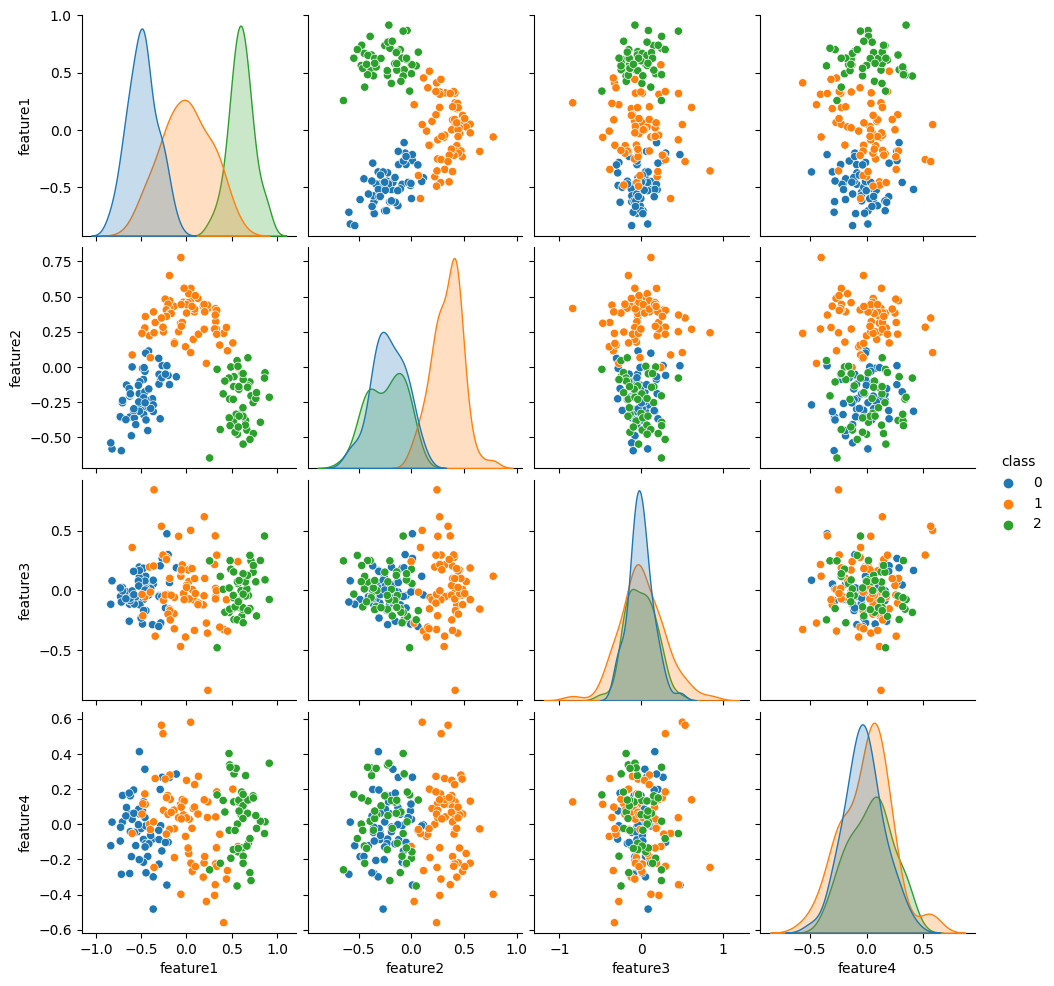

In [7]:
# Limit wine data to 4 features using PCA
wine_features = wine_data.data
wine_labels = wine_data.target

# Apply MinMaxScaler to scale the features
wine_features = MinMaxScaler().fit_transform(wine_features)

# Apply PCA to reduce the number of features to 4
pca = PCA(n_components=4)
wine_features = pca.fit_transform(wine_features)

# Create a DataFrame with the reduced features and class labels
wine_df = pd.DataFrame(wine_features, columns=[
                       'feature1', 'feature2', 'feature3', 'feature4'])
wine_df["class"] = pd.Series(wine_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(wine_df, hue="class", palette="tab10")
plt.show()


# Process breast cancer data

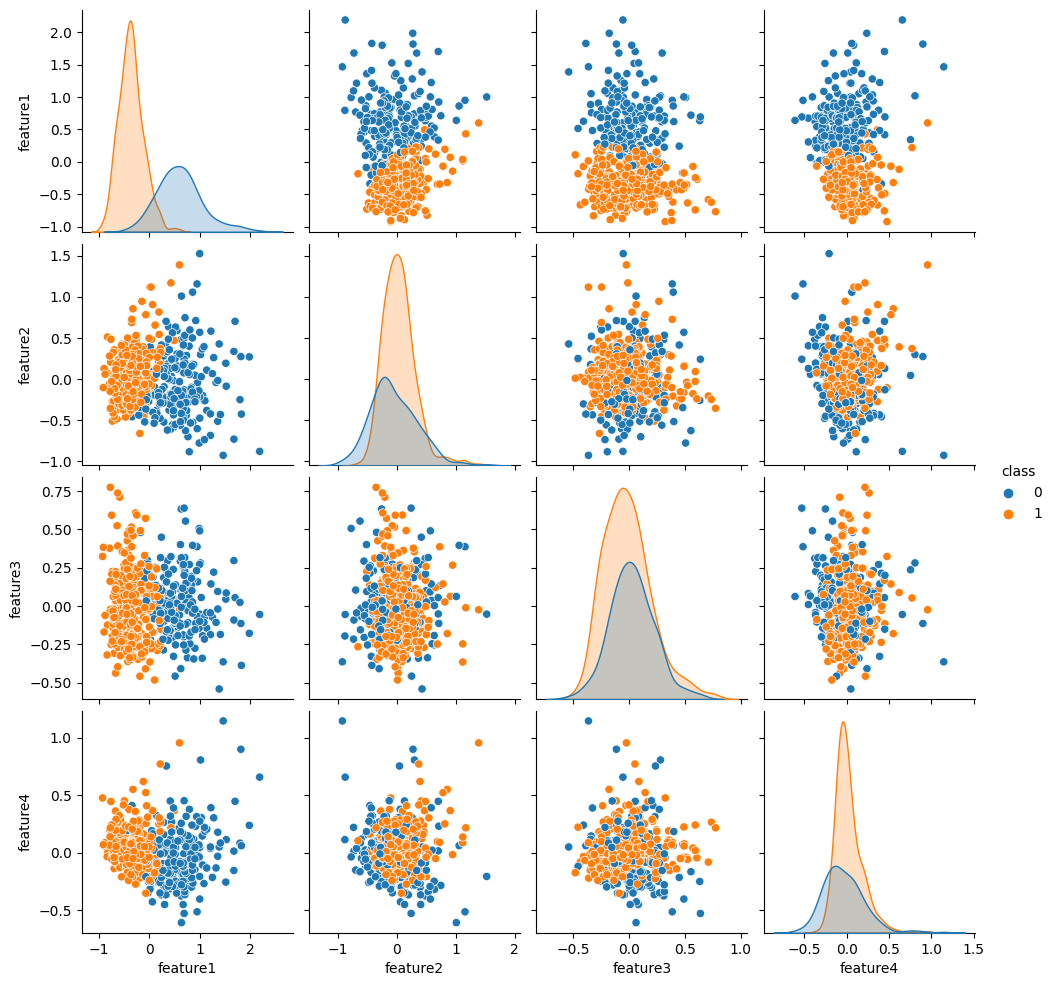

In [8]:
# Limit breast cancer data to 4 features
breast_cancer_features = breast_cancer_data.data
breast_cancer_labels = breast_cancer_data.target

# Apply MinMaxScaler to scale the features
breast_cancer_features = MinMaxScaler().fit_transform(breast_cancer_features)

# Apply PCA to reduce the number of features to 4 due to qubit limitations
pca = PCA(n_components=4)
breast_cancer_features = pca.fit_transform(breast_cancer_features)

# Create a DataFrame with the reduced features and class labels
breast_cancer_df = pd.DataFrame(
    breast_cancer_features, columns=['feature1', 'feature2', 'feature3', 'feature4'])
breast_cancer_df["class"] = pd.Series(breast_cancer_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(breast_cancer_df, hue="class", palette="tab10")
plt.show()


In [9]:
# Split iris data
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    iris_features, iris_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [10]:
# Split wine data
train_features_wine, test_features_wine, train_labels_wine, test_labels_wine = train_test_split(
    wine_features, wine_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [11]:
# Split breast cancer data
train_features_breast_cancer, test_features_breast_cancer, train_labels_breast_cancer, test_labels_breast_cancer = train_test_split(
    breast_cancer_features, breast_cancer_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Iris Classifier

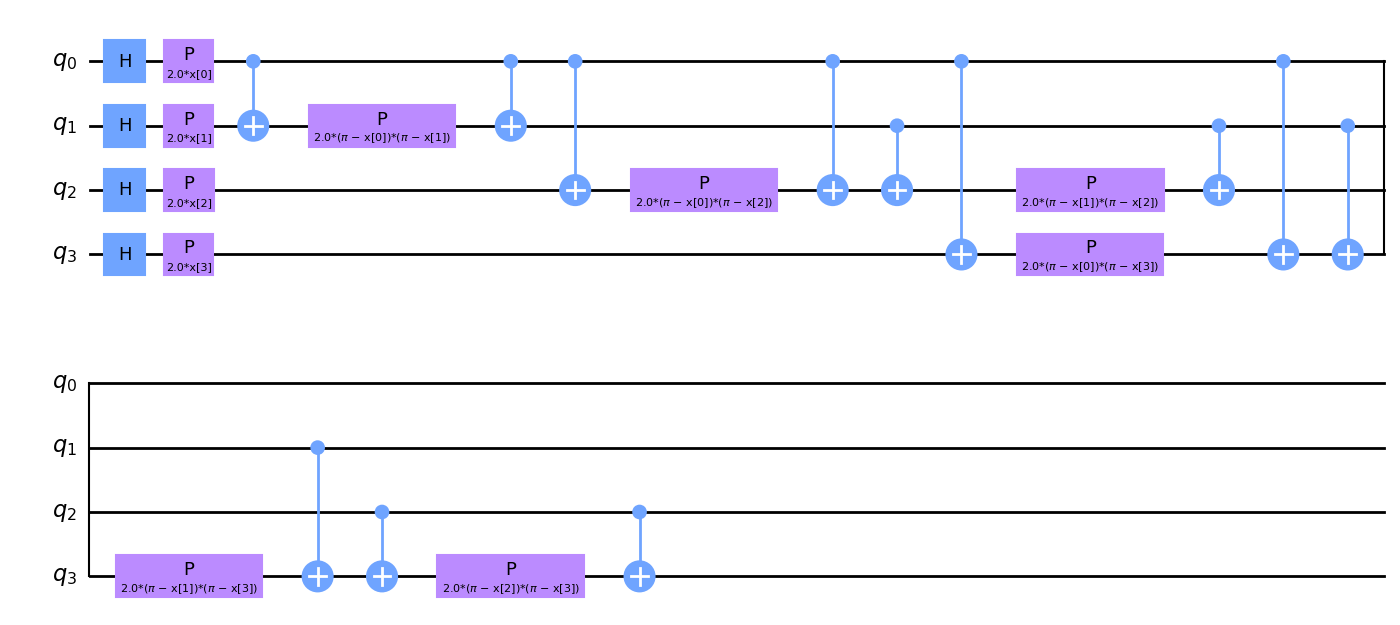

In [12]:
# Create feature map

num_iris_features = iris_features.shape[1]

iris_feature_map = ZZFeatureMap(feature_dimension=num_iris_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
iris_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=iris_feature_map)

iris_feature_map.decompose().draw(output="mpl", fold=20)


## Create Callable Iris Classifier

In [13]:
iris_svc = SVC(kernel=iris_kernel.evaluate)
iris_svc.fit(train_features, train_labels)
iris_score = iris_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {iris_score}")


Callable kernel classification test score: 0.9666666666666667


In [14]:
qsvc = QSVC(quantum_kernel=iris_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")


QSVC classification test score: 0.9666666666666667


# Wine classifier

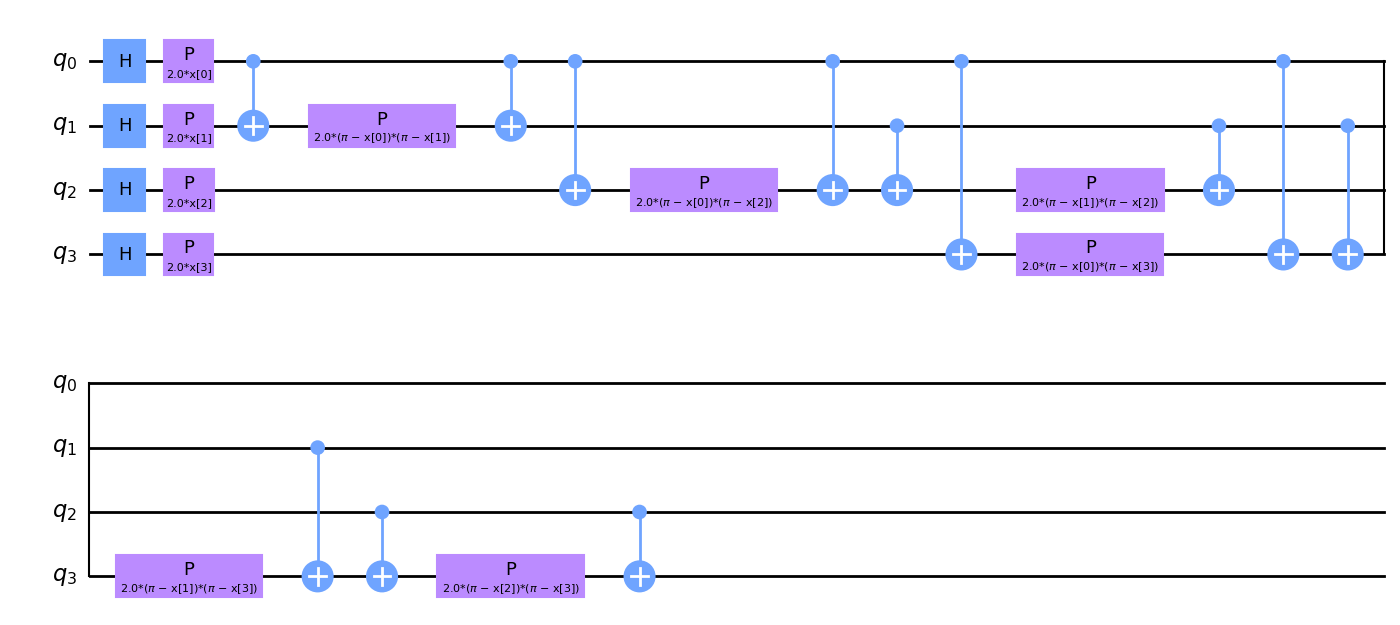

In [15]:
# create wine feature map

num_wine_features = wine_features.shape[1]

wine_feature_map = ZZFeatureMap(feature_dimension=num_wine_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
wine_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=wine_feature_map)

wine_feature_map.decompose().draw(output="mpl", fold=20)


## Create Callable Wine Classifier

In [16]:
wine_svc = SVC(kernel=wine_kernel.evaluate)
wine_svc.fit(train_features_wine, train_labels_wine)
wine_score = wine_svc.score(test_features_wine, test_labels_wine)

print(f"Callable kernel classification test score: {wine_score}")

Callable kernel classification test score: 0.9166666666666666


In [17]:
wine_qsvc = QSVC(quantum_kernel=wine_kernel)
wine_qsvc.fit(train_features_wine, train_labels_wine)
wine_qsvc_score = wine_qsvc.score(test_features_wine, test_labels_wine)

print(f"QSVC classification test score: {wine_qsvc_score}")

QSVC classification test score: 0.9166666666666666


# Breast Cancer Classifier

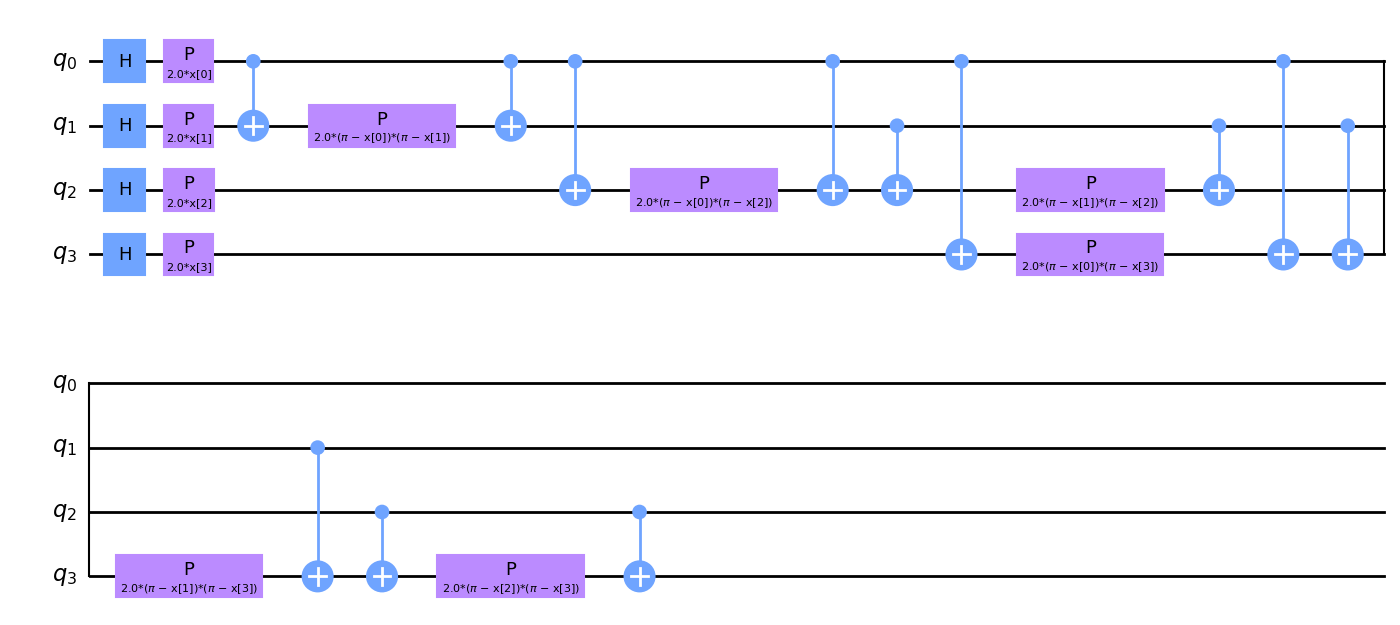

In [18]:
num_breast_cancer_features = breast_cancer_features.shape[1]

breast_cancer_feature_map = ZZFeatureMap(feature_dimension=num_breast_cancer_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
breast_cancer_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=breast_cancer_feature_map)

breast_cancer_feature_map.decompose().draw(output="mpl", fold=20)

## Create Callable Wine Classifier

In [19]:
breast_cancer_svc = SVC(kernel=breast_cancer_kernel.evaluate)
breast_cancer_svc.fit(train_features_breast_cancer, train_labels_breast_cancer)
breast_cancer_score = breast_cancer_svc.score(test_features_breast_cancer, test_labels_breast_cancer)

print(f"Callable kernel classification test score: {breast_cancer_score}")

Callable kernel classification test score: 0.9473684210526315


In [20]:
breast_cancer_qsvc = QSVC(quantum_kernel=breast_cancer_kernel)
breast_cancer_qsvc.fit(train_features_breast_cancer, train_labels_breast_cancer)
breast_cancer_qsvc_score = breast_cancer_qsvc.score(test_features_breast_cancer, test_labels_breast_cancer)

print(f"QSVC classification test score: {breast_cancer_qsvc_score}")

QSVC classification test score: 0.9473684210526315


# Iris Results:

In [21]:
train_score_q4 = qsvc.score(train_features, train_labels)
test_score_q4 = qsvc.score(test_features, test_labels)

print(f"Quantum SVQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum SVQC on the test dataset:     {test_score_q4:.2f}")


Quantum SVQC on the training dataset: 0.99
Quantum SVQC on the test dataset:     0.97


# Wine Results:

In [22]:
train_score_q4_wine = wine_qsvc.score(
    train_features_wine, train_labels_wine)
test_score_q4_wine = wine_qsvc.score(test_features_wine, test_labels_wine)

print(f"Quantum SVQC on the training dataset: {train_score_q4_wine:.2f}")
print(f"Quantum SVQC on the test dataset:     {test_score_q4_wine:.2f}")


Quantum SVQC on the training dataset: 0.99
Quantum SVQC on the test dataset:     0.92


# Breast Cancer Results:

In [23]:
train_score_q4_breast_cancer = breast_cancer_qsvc.score(
    train_features_breast_cancer, train_labels_breast_cancer)
test_score_q4_breast_cancer = breast_cancer_qsvc.score(
    test_features_breast_cancer, test_labels_breast_cancer)

print(f"Quantum SVQC on the training dataset: {train_score_q4_breast_cancer:.2f}")
print(f"Quantum SVQC on the test dataset:     {test_score_q4_breast_cancer:.2f}")

Quantum SVQC on the training dataset: 0.96
Quantum SVQC on the test dataset:     0.95


# Measure other Results:

In [24]:
# Accuracy and resources for iris dataset
accuracy_iris = measure_accuracy(qsvc, test_features, test_labels)
# Accuracy and resources for wine dataset
accuracy_wine = measure_accuracy(
    wine_qsvc, test_features_wine, test_labels_wine)

# Accuracy and resources for breast cancer dataset
accuracy_breast_cancer = measure_accuracy(
    breast_cancer_qsvc, test_features_breast_cancer, test_labels_breast_cancer)

# Send to Runtime

In [25]:
def deploy(deployed_ml, backend):
    transpiled_qc = transpile(deployed_ml.feature_map, backend=backend)
    noise_count = []
    accuracy = 0

    # For each test feature
    for i in range(len(test_features)):
        qc = transpiled_qc
        qc = qc.bind_parameters(test_features[i])
        job = backend.run(qc, shots=100)
        job_id = job.id()
        job_monitor(job)
        result = job.result()
        counts = {format(n, "03b"): 0 for n in range(8)}
        counts.update(result.get_counts(qc))

        non_binary_keys = [key for key in counts if len(
            key) > 3 or not all(c in '01' for c in key)]

        noise_count.append(sum(counts[key] for key in non_binary_keys))

        binary_dict = {k: v for k, v in counts.items() if set(k) <= {'0', '1'}}

        # Get the most frequently observed bitstring (i.e., the predicted class label)
        predicted_bitstring = max(binary_dict, key=counts.get)

        # Convert the binary bitstring to a decimal integer
        predicted_class = int(predicted_bitstring, 2)

        # Compare result against ground-truth label and add to accuracy score if correct
        if predicted_class == test_labels[i]:
            accuracy += 1

    accuracy /= len(test_features)
    noise = sum(noise_count) / len(test_features)
    return accuracy, noise


# Deploy to Simulator

In [30]:
iris_simulator_accuracy, iris_simulator_noise = deploy(qsvc.quantum_kernel, simulator_backend)
memory_iris, cpu_iris = measure_resources()

print(
    f"Iris Accuracy: {iris_simulator_accuracy:.2f}, Iris Noise: {iris_simulator_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [29]:
iris_quantinuum_accuracy, iris_quantinuum_noise = deploy(
    qsvc.quantum_kernel, quantinuum_backend)

memory_quantinuum, cpu_quantinuum = measure_resources()

print(
    f"Iris Accuracy: {iris_quantinuum_accuracy:.2f}, Iris Noise: {iris_quantinuum_noise:.2f}")


Job Status: job incurred error


TypeError: sequence item 0: expected str instance, NoneType found

In [31]:
iris_rigetti_accuracy, iris_rigetti_noise = deploy(
    qsvc.quantum_kernel, rigetti_backend)

memory_rigetti, cpu_rigetti = measure_resources()

print(
    f"Iris Accuracy: {iris_rigetti_accuracy:.2f}, Iris Noise: {iris_rigetti_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [32]:
wine_simulator_accuracy, wine_simulator_noise = deploy(
    wine_qsvc.quantum_kernel, simulator_backend)
memory_wine, cpu_wine = measure_resources()
print(
    f"Wine Accuracy: {wine_simulator_accuracy:.2f}, Wine Noise: {wine_simulator_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [33]:
wine_quantinuum_accuracy, wine_quantinuum_noise = deploy(
    wine_qsvc.quantum_kernel, quantinuum_backend)

wine_memory_quantinuum, wine_cpu_quantinuum = measure_resources()

print(
    f"Iris Accuracy: {wine_quantinuum_accuracy:.2f}, Iris Noise: {wine_quantinuum_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [34]:
wine_rigetti_accuracy, wine_rigetti_noise = deploy(
    wine_qsvc.quantum_kernel, rigetti_backend)

wine_memory_rigetti, wine_cpu_rigetti = measure_resources()

print(
    f"Iris Accuracy: {wine_rigetti_accuracy:.2f}, Iris Noise: {wine_rigetti_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [35]:

breast_cancer_simulator_accuracy, breast_cancer_simulator_noise = deploy(
    breast_cancer_qsvc.quantum_kernel, simulator_backend)
memory_breast_cancer, cpu_breast_cancer = measure_resources()
print(
    f"Breast Cancer Accuracy: {breast_cancer_simulator_accuracy:.2f}, Breast Cancer Noise: {breast_cancer_simulator_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [36]:
breast_cancer_quantinuum_accuracy, breast_cancer_quantinuum_noise = deploy(
    breast_cancer_qsvc.quantum_kernel, quantinuum_backend)

breast_cancer_memory_quantinuum, breast_cancer_cpu_quantinuum = measure_resources()

print(
    f"Iris Accuracy: {breast_cancer_quantinuum_accuracy:.2f}, Iris Noise: {breast_cancer_quantinuum_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [37]:
breast_cancer_rigetti_accuracy, breast_cancer_rigetti_noise = deploy(
    breast_cancer_qsvc.quantum_kernel, rigetti_backend)

breast_cancer_memory_rigetti, breast_cancer_cpu_rigetti = measure_resources()

print(
    f"Iris Accuracy: {breast_cancer_rigetti_accuracy:.2f}, Iris Noise: {breast_cancer_rigetti_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

# Deploy to Real Device

In [38]:
iris_ionq_accuracy, iris_ionq_noise = deploy(qsvc.quantum_kernel, ionq_backend)

memory_iris_ionq, cpu_iris_ionq = measure_resources()

print(
    f"Iris Accuracy: {iris_ionq_accuracy:.2f}, Iris Noise: {iris_ionq_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [39]:
wine_ionq_accuracy, wine_ionq_noise = deploy(
    wine_qsvc.quantum_kernel, ionq_backend)

memory_wine_ionq, cpu_wine_ionq = measure_resources()

print(
    f"Wine Accuracy: {wine_ionq_accuracy:.2f}, Wine Noise: {wine_ionq_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [40]:

breast_cancer_ionq_accuracy, breast_cancer_ionq_noise = deploy(
    breast_cancer_qsvc.quantum_kernel, ionq_backend)

memory_breast_cancer_ionq, cpu_breast_cancer_ionq = measure_resources()

print(
    f"Breast Cancer Accuracy: {breast_cancer_ionq_accuracy:.2f}, Breast Cancer Noise: {breast_cancer_ionq_noise:.2f}")


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

# Print results to a csv

In [41]:
# Create table of results

results = pd.DataFrame(
    {
        "Dataset": ["Iris", "Wine", "Breast Cancer"],
        "Simulator Accuracy": [iris_simulator_accuracy, wine_simulator_accuracy, breast_cancer_simulator_accuracy],
        "Simulator Noise": [iris_simulator_noise, wine_simulator_noise, breast_cancer_simulator_noise],
        "IonQ Accuracy": [iris_ionq_accuracy, wine_ionq_accuracy, breast_cancer_ionq_accuracy],
        "IonQ Noise": [iris_ionq_noise, wine_ionq_noise, breast_cancer_ionq_noise],
        "Quantinuum Accuracy": [iris_quantinuum_accuracy, wine_quantinuum_accuracy, breast_cancer_quantinuum_accuracy],
        "Quantinuum Noise": [iris_quantinuum_noise, wine_quantinuum_noise, breast_cancer_quantinuum_noise],
        "Rigetti Accuracy": [iris_rigetti_accuracy, wine_rigetti_accuracy, breast_cancer_rigetti_accuracy],
        "Rigetti Noise": [iris_rigetti_noise, wine_rigetti_noise, breast_cancer_rigetti_noise],
        "Train Score": [train_score_q4, train_score_q4_wine, train_score_q4_breast_cancer],
        "Test Score": [test_score_q4, test_score_q4_wine, test_score_q4_breast_cancer],
        "Non-Simulator Accuracy": [accuracy_iris, accuracy_wine, accuracy_breast_cancer],
        "Memory": [memory_iris, memory_wine, memory_breast_cancer],
        "CPU": [cpu_iris, cpu_wine, cpu_breast_cancer],
        "Memory IonQ": [memory_iris_ionq, memory_wine_ionq, memory_breast_cancer_ionq],
        "CPU IonQ": [cpu_iris_ionq, cpu_wine_ionq, cpu_breast_cancer_ionq],
        "Memory Quantinuum": [memory_quantinuum, wine_memory_quantinuum, breast_cancer_memory_quantinuum],
        "CPU Quantinuum": [cpu_quantinuum, wine_cpu_quantinuum, breast_cancer_cpu_quantinuum],
        "Memory Rigetti": [memory_rigetti, wine_memory_rigetti, breast_cancer_memory_rigetti],
        "CPU Rigetti": [cpu_rigetti, wine_cpu_rigetti, breast_cancer_cpu_rigetti]
    }
)

# Print results to a csv file

results.to_csv("QSVC_runtime_results.csv", index=False)
